# Process Normalized Cross-Study Dataset

For differential expression analysis, we processed all of the data together on a high memory node.  This was done using the minfi package in R, and all data were normalized using the preprocessQuantile function.  For a full script of the R pipeline see the [Methylation_Normalization_MINFI](./Methylation_Normalization_MINFI.ipynb) notebook.

Imports and helper functions from [Imports](Imports.ipynb) notebook.

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


### Read in Validation Data

In [3]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [4]:
df_hiv =  pd.read_csv(path + 'betas_BMIQ.csv', index_col=0)

#### Read in annotations 

In [5]:
hiv_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx', 
                        sheetname='HIV', skiprows=2, index_col=0)
control_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx',
                            sheetname='Negative', skiprows=2, index_col=0)
ann = pd.concat([hiv_ann, control_ann], keys=['HIV+','HIV-'])
ann = ann.reset_index()
ann = ann.rename(columns={'Age (years)': 'age', 'level_0':'HIV'})
ann = ann.set_index('PATID')
ann = ann.ix[df_hiv.columns]

In [6]:
from IPython.display import clear_output
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [7]:
import statsmodels.api as sm

In [8]:
hiv = ann.HIV == 'HIV+'
intercept = pd.Series(1, index=hiv.index)
age = ann.age

X = pd.concat([intercept, hiv, age], axis=1, 
              keys=['Intercept','HIV', 'age'])
X_reduced = X[['Intercept','HIV']]

w = (len(hiv) - hiv.map(hiv.value_counts())).astype(float) / len(hiv)
w = w.ix[X.index]

X = X.ix[df_hiv.columns]

In [9]:
%%time
p = {}
d_hiv = {}

df = logit_adj(df_hiv)
for i,y in df.iterrows():
    y.name = 'marker'
    y = logit_adj(y)
    mod_all = sm.WLS(y, X, weights=w)
    res_ref = mod_all.fit()
    p[i] = res_ref.params
    
    mod_reduced = sm.WLS(y, X_reduced, weights=w)
    m1 = mod_reduced.fit()
    d_hiv[i] = res_ref.compare_lr_test(m1)

coef = pd.DataFrame(p).T
d_age = pd.DataFrame(d_hiv, index=['LR','p','df']).T

CPU times: user 26min 41s, sys: 4.33 s, total: 26min 45s
Wall time: 26min 48s


In [11]:
monocyte_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/monocyte_age_corr.csv',
                            index_col=0, squeeze=True)

In [15]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

In [10]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [32]:
import Setup.DX_Imports as dx

In [12]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [13]:
dx = bhCorrection(d_hiv.p) < .05
dx.value_counts()

False    441114
True      44398
dtype: int64

In [14]:
mm = df_hiv.mean(1)

In [15]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

In [16]:
a,b = match_series((fx.mm > .5), (p.HIV < 0))
a,b = match_series(a,b)
direction = a == b

hiv_bh = dx 
hiv_bh = (hiv_bh & (direction == False) & (fx.g_age == False)).dropna()
hiv_bh = hiv_bh.ix[probe_idx].ix[ann.index].dropna()
#hiv_bh = hiv_bh & (t_hiv.abs() > 1) 
hiv_bh.value_counts()

False    454866
True      18178
dtype: int64

In [17]:
dx_gran = bhCorrection(d_hiv.p) < .01
dx_gran.value_counts()

False    468259
True      17253
dtype: int64

In [197]:
dx_gran_u = bhCorrection(d_hiv.p.ix[ti(fx.g_hiv == True)]) < .01
dx_gran_d = bhCorrection(d_hiv.p.ix[ti(fx.g_hiv == False)]) < .01
dx_gran_u.mean() / dx_gran_d.mean()

3.285441282439364

In [199]:
dx_gran_t = bhCorrection(d_hiv.p.ix[ti(fx.g_hiv == True)]) < .01
dx_gran_t.value_counts()

False    74028
True      7333
dtype: int64

In [162]:
fisher_exact_test(direction, dx_gran)

odds_ratio    7.52e-01
p             2.17e-75
dtype: float64

In [130]:
fx.g_age.value_counts()

False    446117
True      26927
dtype: int64

In [141]:
r = pd.concat([fx.g_age, dx_gran, fx.g_hiv], 
              keys=['age','pure','mixed'], axis=1).dropna().astype(int).astype(str).apply(lambda s: ''.join(s), axis=1)

In [150]:
fisher_exact_test(fx.g_age, d_hiv.p.rank() < sum(fx.g_hiv))

odds_ratio     1.56e+00
p             1.18e-184
dtype: float64

In [153]:
d = df_hiv.groupby(hiv, axis=1).mean()
dx = d[1] - d[0]

In [161]:
fisher_exact_test(combine(fx.g_age, fx.g_hiv) == 'both', dx_gran)

odds_ratio    2.31e+00
p             9.62e-51
dtype: float64

In [159]:
fisher_exact_test(fx.g_age, dx_gran)

odds_ratio    1.76e+00
p             1.20e-84
dtype: float64

In [190]:
fisher_exact_test(fx.g_hiv, dx_gran)

odds_ratio    2.21
p             0.00
dtype: float64

In [63]:
fisher_exact_test(fx.g_hiv_nom, d_hiv.p < .01)

odds_ratio    1.7
p             0.0
dtype: float64

In [18]:
fisher_exact_test(fx.g_hiv.ix[ti(direction == False)], dx_gran)

odds_ratio    1.31e+00
p             4.07e-20
dtype: float64

In [20]:
fisher_exact_test(fx.g_hiv.ix[ti(direction)], dx_gran)

odds_ratio    3.59
p             0.00
dtype: float64

In [21]:
pd.crosstab(fx.g_hiv, dx_gran)

d,False,True
h,,
False,379832,11851
True,76106,5255


In [22]:
ann.Gene_Symbol.ix[ti(fx.g_hiv & dx_gran)].value_counts().head()

RASA3      8
TBCD       8
PRKCZ      7
HDAC4      7
CBFA2T3    6
dtype: int64

In [23]:
dd = dx_gran.ix[ti(fx.g_hiv)]
m = dd.mean()
w = 10
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

In [25]:
fisher_exact_test(dx_gran.ix[ti(direction==False)], ann.Gene_Symbol=='HCP5')

odds_ratio    5.23
p             0.07
dtype: float64

In [133]:
ann.ix[ti(hiv_bh)].Gene_Symbol.value_counts().head()

HCP5              3
CAPN2             2
JMJD6;C17orf95    2
TFDP1             2
ABLIM1            1
dtype: int64

In [26]:
m = hiv_bh.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               hiv_bh.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

In [27]:
def manhattan(vec, chrom, coords, ax=None, ybound=None,
              flow='up', ticks=True, gap=3e7):
    fig, ax = init_ax(ax, figsize=(9,3))
    x = 0
    chr_coords = []
    for i,c in enumerate(map(str, range(1,23))):
        v = vec.ix[ti(chrom == c)].dropna()
        series_scatter(coords + x, v, s=10, ax=ax, 
                       color=colors[i % 5], 
                       ann=None, alpha=1, rasterized=True) 
        chr_len = coords.ix[v.index].max()
        x = x + chr_len + gap
        chr_coords += [x - (chr_len / 2.)]
    ax.set_xbound(gap, x + gap)
    if ybound is not None:
        ax.set_ybound(ybound[0],ybound[1])
    ax.set_xlabel('Chromosome')
    
    if ticks:
        ax.set_xticks(chr_coords)
        ax.set_xticklabels(map(str, range(1,23)))
    else:
        ax.set_xticks([])
    top = flow == 'down'
    prettify_ax(ax, top)

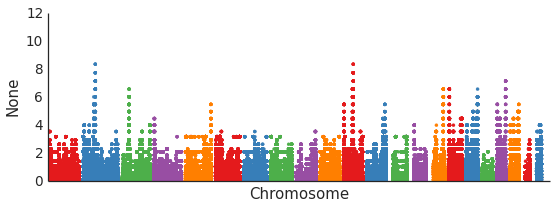

In [28]:
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,12], ticks=False)

In [29]:
full_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
histone_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 29570008)))
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [30]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

In [17]:
hiv.sort_index()

FOX201    False
FOX202    False
FOX203    False
FOX204    False
FOX205    False
FOX206    False
FOX207    False
FOX208    False
FOX209    False
FOX211    False
FOX212    False
FOX213    False
FOX214    False
FOX215    False
FOX216    False
FOX217    False
FOX218    False
FOX219    False
FOX221    False
FOX222    False
FOX224    False
FOX225    False
FOX227    False
FOX351     True
FOX352     True
FOX353     True
FOX354     True
FOX355     True
FOX356     True
FOX357     True
FOX361     True
FOX362     True
FOX363     True
FOX365     True
FOX366     True
FOX369     True
FOX374     True
FOX375     True
FOX376     True
FOX377     True
FOX378     True
FOX379     True
FOX380     True
FOX381     True
FOX382     True
FOX383     True
FOX384     True
FOX385     True
Name: HIV, dtype: bool

In [55]:
tt = dx.ttest_df(hiv, df_hiv)

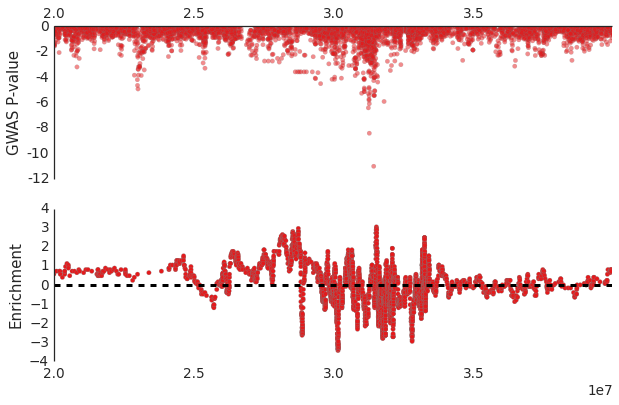

In [75]:
fig, axs  = subplots(2,1, figsize=(10,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

d = (tt[tt.abs() > 0] > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 200, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
v = (v - v.mean()) / v.std()

series_scatter(x[::5], v.ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

In [76]:
fisher_exact_test(dx, hla_region)

odds_ratio   NaN
p            NaN
dtype: float64

In [58]:
fx.g_hiv_b.value_counts()

False    455008
True      18036
dtype: int64

In [59]:
fisher_exact_test(fx.g_hiv_b, dx)

odds_ratio   NaN
p            NaN
dtype: float64

In [81]:
DX = dx

In [84]:
def draw_dist_by_annotation(f, ax):
    lw = 2.5
    draw_dist(f.ix[ti(DX.probe_sets['Promoter'])], ax=ax)
    draw_dist(f.ix[ti(DX.probe_sets['CpG Island'])], ax=ax)
    draw_dist(f.ix[ti(DX.probe_sets['PRC2'])], ax=ax)
    draw_dist(f, ax=ax, colors='grey')
    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
    prettify_ax(ax)
    return ax

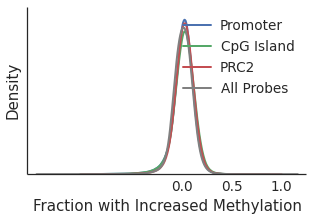

In [85]:
pd.crosstab()

In [89]:
probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [182]:
d2 = bhCorrection(d_hiv.p) < .01
d2 = d2.ix[ti(fx.mm < .5)]
d2.value_counts()

False    203574
True      13703
dtype: int64

In [183]:
associations = {}
for j,b in probes_sets.iteritems():
    associations[j] = fisher_exact_test(d2,b.ix[fx.probe_idx])
associations = pd.concat(associations)

In [184]:
associations.unstack()

,odds_ratio,p
CpG island,2.46,0.00e+00
DHS,0.89,1.84e-07
Enhancer,0.85,1.10e-10
Gene body,0.99,5.29e-01
PRC2,0.93,2.85e-04
Promoter,1.21,1.22e-27
TSS,1.10,2.41e-08


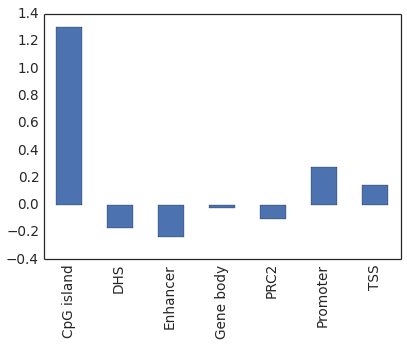

In [185]:
np.log2(associations.ix[:,'odds_ratio']).plot(kind='bar')

In [174]:
fisher_exact_test(fx.mm < .5, fx.g_hiv)

odds_ratio     1.18e+00
p             8.86e-107
dtype: float64

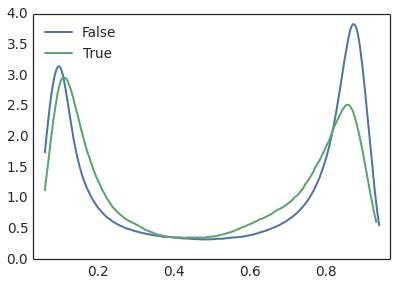

In [178]:
draw_dist(fx.mm, fx.g_hiv)

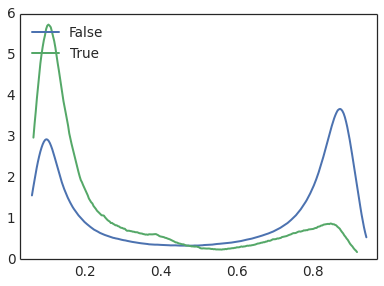

In [181]:
draw_dist(fx.mm, dx_gran)

In [173]:
fisher_exact_test(fx.mm < .5, dx_gran)

odds_ratio    5.02
p             0.00
dtype: float64

In [186]:
d2 = bhCorrection(d_hiv.p) < .01
d2 = d2.ix[ti(fx.mm > .5)]
d2.value_counts()

False    264685
True       3550
dtype: int64

In [187]:
associations = {}
for j,b in probes_sets.iteritems():
    associations[j] = fisher_exact_test(d2,b.ix[fx.probe_idx])
associations = pd.concat(associations)

In [188]:
associations.unstack()

,odds_ratio,p
CpG island,1.15,3.44e-02
DHS,1.28,1.64e-04
Enhancer,0.78,1.57e-09
Gene body,1.27,4.28e-12
PRC2,0.98,7.93e-01
Promoter,2.07,4.64e-16
TSS,0.99,9.05e-01


In [124]:
d2 = bhCorrection(d_hiv.p.ix[ti(fx.g_hiv)]) < .01
d2 = d2.ix[fx.g_hiv.index].fillna(False)
d2.value_counts()

False    465711
True       7333
dtype: int64

In [125]:
associations = {}
for j,b in probes_sets.iteritems():
    associations[j] = fisher_exact_test(d2, b.ix[fx.probe_idx])
associations = pd.concat(associations)

In [126]:
associations.unstack()

,odds_ratio,p
CpG island,3.29,0.00e+00
DHS,1.28,2.40e-13
Enhancer,0.66,2.37e-40
Gene body,0.80,1.15e-18
PRC2,1.58,3.52e-56
Promoter,1.82,1.66e-114
TSS,1.49,1.37e-57


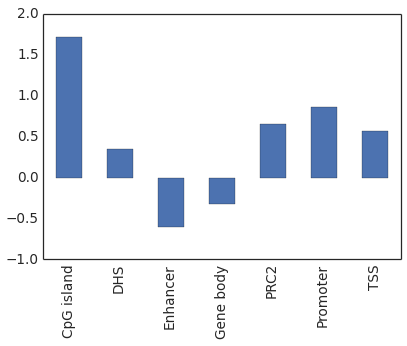

In [127]:
np.log2(associations.ix[:,'odds_ratio']).plot(kind='bar')